# Prepare dataframe

In [1]:
# Import the following modules for SUPSI Laptop

# System
# ==============================================================================
import time
import os
from pathlib import Path
import datetime

# Data manipulation
# ==============================================================================
import pandas as pd
import numpy as np
import scipy
from math import sqrt
from scipy import stats
from numpy.linalg import matrix_rank

# Calculate sunrise and sunset
# ==============================================================================
from suntime import Sun, SunTimeException
from dateutil import tz # Include this package for defining time zone for Sun module
import pytz # Include this package for defining time zone for Sun module, choose to use later either tz or pytz

# Modelling 
# ==============================================================================
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline, Pipeline

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
import statsmodels.api as sm
import seaborn as sns
import seaborn

seaborn.set()

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")
print(f"{color}Version scipy: {scipy.__version__}")
  
# Change the directory and jump to the location where you want to arrange the files
os.chdir(r"C:\Users\tianshen.liang\OneDrive - SUPSI\OneDrive\SUPSI work files\BIPVdSHADE\data_analysis\Dec22-Nov24-2years_v2")

path_irr = r'C:\Users\tianshen.liang\OneDrive - SUPSI\OneDrive\SUPSI work files\BIPVdSHADE\data_analysis\Dec22-Nov24-2years_v2\Irradiance-1min.csv'
path_im = r'C:\Users\tianshen.liang\OneDrive - SUPSI\OneDrive\SUPSI work files\BIPVdSHADE\data_analysis\Dec22-Nov24-2years_v2\Im-data-1min.csv'
path_vm = r'C:\Users\tianshen.liang\OneDrive - SUPSI\OneDrive\SUPSI work files\BIPVdSHADE\data_analysis\Dec22-Nov24-2years_v2\Vm-data-1min.csv'

Version scikit-learn: 1.6.1
Version pandas: 2.2.3
Version numpy: 1.26.4
Version scipy: 1.11.4


In [2]:
# GHI, DHI dataset
# Read data from csv, set Time as index, convert the datatype of Time, and rename Time to Timestamp

df_irr = pd.read_csv(path_irr, header=0, names=['Time', 'GHI', 'DHI']) #header is 0 or 1??
df_irr.set_index('Time', inplace = True)
df_irr.index = pd.to_datetime(df_irr.index)
df_irr = df_irr.rename_axis('Timestamp')
df_irr.dtypes

# Check NaN values
count_nan = df_irr.isna().sum().sum()
print ('Count of NaN for irr: ' + str(count_nan))
print('Dtype for Irradiance data: ' + str(df_irr.dtypes))
print('\n')

######################################################################################################
# Module max. current dataset

df_im = pd.read_csv(path_im, header = 0)
df_im.set_index('Time', inplace = True)
df_im.index = pd.to_datetime(df_im.index)
df_im = df_im.rename_axis('Timestamp')

# Check NaN values
count_nan = df_im.isna().sum().sum()
print ('Count of NaN for im: ' + str(count_nan))
print('Dtype for Current data: ' + str(df_im.dtypes))
print('\n')

######################################################################################################
# Module max. voltage dataset
# Read data from csv, set Time as index, convert the datatype of Time, and rename Time to Timestamp

df_vm = pd.read_csv(path_vm, header = 0)
df_vm.set_index('Time', inplace = True)
df_vm.index = pd.to_datetime(df_vm.index)
df_vm = df_vm.rename_axis('Timestamp')

# Check NaN values
count_nan = df_vm.isna().sum().sum()
print ('Count of NaN for vm: ' + str(count_nan))
print('Dtype for Voltage data: ' + str(df_vm.dtypes))
print('\n')

Count of NaN for irr: 264416
Dtype for Irradiance data: GHI    float64
DHI    float64
dtype: object


Count of NaN for im: 592761
Dtype for Current data: Im_MPPT 246 / L4+L5           float64
Im_MPPT 286/ L2+L3 Left       float64
Im_MPPT 287 / L2+L3 Right     float64
dtype: object


Count of NaN for vm: 592761
Dtype for Voltage data: Vm_MPPT 246 / L4+L5           float64
Vm_MPPT 286/ L2+L3 Left       float64
Vm_MPPT 287 / L2+L3 Right     float64
dtype: object




In [3]:
# Update with inspection of dataframe

print(df_irr.info())
print('\n')
print(df_im.info())
print('\n')
print(df_vm.info())
print('\n')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1052640 entries, 2022-12-01 00:00:00 to 2024-11-30 23:59:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   GHI     920432 non-null  float64
 1   DHI     920432 non-null  float64
dtypes: float64(2)
memory usage: 24.1 MB
None


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1052640 entries, 2022-12-01 00:00:00 to 2024-11-30 23:59:00
Data columns (total 3 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Im_MPPT 246 / L4+L5         937911 non-null  float64
 1   Im_MPPT 286/ L2+L3 Left     796317 non-null  float64
 2   Im_MPPT 287 / L2+L3 Right   830931 non-null  float64
dtypes: float64(3)
memory usage: 32.1 MB
None


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1052640 entries, 2022-12-01 00:00:00 to 2024-11-30 23:59:00
Data columns (total 3 columns):
 #   Column                

In [4]:
# Replace negative value with zero, To think: is this method scientific?

df_irr = df_irr.mask(df_irr < 0, 0)

In [5]:
# Rename columns' name

df_im = df_im.rename(columns = {df_im.columns[0] : "Im_246/L4+L5", df_im.columns[1] : "Im_286/L2+L3 Left", df_im.columns[2] : "Im_287/L2+L3 Right"}, errors = "raise")

df_vm = df_vm.rename(columns = {df_vm.columns[0] : 'Vm_246/L4+L5', df_vm.columns[1] : 'Vm_286/L2+L3 Left', df_vm.columns[2] : 'Vm_287/L2+L3 Right'}, errors = "raise")

In [6]:
# Add columns with year, month, and weekday 

# Comment: this step is rather unnecessary as we can specify year, month, day from the datetime index

df_irr['Year'] = df_irr.index.year.astype(int)
df_irr['Month'] = df_irr.index.month.astype(int)
df_irr['Day'] = df_irr.index.day.astype(int)
df_irr['Time'] = df_irr.index.time

# Display a random sampling of 5 rows
df_irr.sample(5, random_state=0)
#print(df_temp.dtypes)

,GHI,DHI,Year,Month,Day,Time
Timestamp,,,,,,
2024-01-29 00:19:00,0.0,0.0,2024,1,29,00:19:00
2024-05-28 19:21:00,0.0,0.0,2024,5,28,19:21:00
2023-01-26 18:09:00,0.0,0.0,2023,1,26,18:09:00
2023-01-30 12:15:00,444.0,80.4,2023,1,30,12:15:00
2023-03-16 04:41:00,0.0,0.0,2023,3,16,04:41:00


# Create sunrise and sunset hour

In [7]:
# loop through the rows using iterrows() to calculate the sunrise and sunset hour

latitude = 45.8713 #Mendrisio's location
longitude = 8.9841

sun = Sun(latitude, longitude)

sunrise = []
sunset = []

for index, row in df_irr.iterrows():
    abd = datetime.datetime(row['Year'], row['Month'], row['Day']) #year, month, day; REPLACE date with datetime
    abd_sr = sun.get_sunrise_time(abd, tz.gettz('Europe/Zurich')) # UPDATE by adding tz.gettz for obtaining LOCAL sunset time
    abd_ss = sun.get_sunset_time(abd, tz.gettz('Europe/Zurich'))
    sunrise.append(abd_sr.strftime('%H:%M:%S'))
    sunset.append(abd_ss.strftime('%H:%M:%S'))
    
df_irr['Sunrise'] = sunrise 
df_irr['Sunset'] = sunset 

df_irr

,GHI,DHI,Year,Month,Day,Time,Sunrise,Sunset
Timestamp,,,,,,,,
2022-12-01 00:00:00,0.0,0.0,2022,12,1,00:00:00,07:44:24,16:40:48
2022-12-01 00:01:00,0.0,0.0,2022,12,1,00:01:00,07:44:24,16:40:48
2022-12-01 00:02:00,0.0,0.0,2022,12,1,00:02:00,07:44:24,16:40:48
2022-12-01 00:03:00,0.0,0.0,2022,12,1,00:03:00,07:44:24,16:40:48
2022-12-01 00:04:00,0.0,0.0,2022,12,1,00:04:00,07:44:24,16:40:48
...,...,...,...,...,...,...,...,...
2024-11-30 23:55:00,0.0,0.0,2024,11,30,23:55:00,07:44:24,16:40:48
2024-11-30 23:56:00,0.0,0.0,2024,11,30,23:56:00,07:44:24,16:40:48
2024-11-30 23:57:00,0.0,0.0,2024,11,30,23:57:00,07:44:24,16:40:48


In [8]:
# Join all dataframes

df_combined = pd.concat([df_irr, df_im, df_vm], axis = 1) #To DO: integrate df_clrsky

column_to_move = df_combined.pop('Year')
column_to_move1 = df_combined.pop('Month')
column_to_move2 = df_combined.pop('Day')
column_to_move3 = df_combined.pop('Time')
column_to_move4 = df_combined.pop('Sunrise')
column_to_move5 = df_combined.pop('Sunset')


# insert column with insert(location, column_name, column_value)

df_combined.insert(0, 'Year', column_to_move)
df_combined.insert(1, 'Month', column_to_move1)
df_combined.insert(2, 'Day', column_to_move2)
df_combined.insert(3, 'Time', column_to_move3)
df_combined.insert(4, 'Sunrise', column_to_move4)
df_combined.insert(5, 'Sunset', column_to_move5)

df_combined

,Year,Month,Day,Time,Sunrise,Sunset,GHI,DHI,Im_246/L4+L5,Im_286/L2+L3 Left,Im_287/L2+L3 Right,Vm_246/L4+L5,Vm_286/L2+L3 Left,Vm_287/L2+L3 Right
Timestamp,,,,,,,,,,,,,,
2022-12-01 00:00:00,2022,12,1,00:00:00,07:44:24,16:40:48,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
2022-12-01 00:01:00,2022,12,1,00:01:00,07:44:24,16:40:48,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
2022-12-01 00:02:00,2022,12,1,00:02:00,07:44:24,16:40:48,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
2022-12-01 00:03:00,2022,12,1,00:03:00,07:44:24,16:40:48,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
2022-12-01 00:04:00,2022,12,1,00:04:00,07:44:24,16:40:48,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30 23:55:00,2024,11,30,23:55:00,07:44:24,16:40:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-30 23:56:00,2024,11,30,23:56:00,07:44:24,16:40:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-30 23:57:00,2024,11,30,23:57:00,07:44:24,16:40:48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Filtering/Cleaning

In [9]:
# Data filtering Step 1: Drop row before sunrise and after sunset with zero

df_combined['Time'] = df_combined['Time'].astype(str)

df_combined.drop(df_combined[df_combined['Time'] <= df_combined['Sunrise']].index, inplace = True)
df_combined.drop(df_combined[df_combined['Time'] >= df_combined['Sunset']].index, inplace = True)

In [10]:
# Add new column with arithmetic operation
df_combined['Pm_246/L4+L5'] = df_combined['Im_246/L4+L5'] * df_combined['Vm_246/L4+L5']
df_combined['Pm_286/L2+L3 Left'] = df_combined['Im_286/L2+L3 Left'] * df_combined['Vm_286/L2+L3 Left']
df_combined['Pm_287/L2+L3 Right'] = df_combined['Im_287/L2+L3 Right'] * df_combined['Vm_287/L2+L3 Right']
df_combined['Pm_L2+L3 Total'] = df_combined['Pm_286/L2+L3 Left'] + df_combined['Pm_287/L2+L3 Right']
df_combined

,Year,Month,Day,Time,Sunrise,Sunset,GHI,DHI,Im_246/L4+L5,Im_286/L2+L3 Left,Im_287/L2+L3 Right,Vm_246/L4+L5,Vm_286/L2+L3 Left,Vm_287/L2+L3 Right,Pm_246/L4+L5,Pm_286/L2+L3 Left,Pm_287/L2+L3 Right,Pm_L2+L3 Total
Timestamp,,,,,,,,,,,,,,,,,,
2022-12-01 07:45:00,2022,12,1,07:45:00,07:44:24,16:40:48,96.3,33.3,1.97,2.27,NaN,14.4,6.86,NaN,28.368,15.5722,NaN,NaN
2022-12-01 07:46:00,2022,12,1,07:46:00,07:44:24,16:40:48,97.7,33.5,1.99,2.28,NaN,14.3,6.88,NaN,28.457,15.6864,NaN,NaN
2022-12-01 07:47:00,2022,12,1,07:47:00,07:44:24,16:40:48,99.3,33.8,2.01,2.28,NaN,14.3,6.90,NaN,28.743,15.7320,NaN,NaN
2022-12-01 07:48:00,2022,12,1,07:48:00,07:44:24,16:40:48,101.0,34.1,2.04,2.31,NaN,14.3,6.86,NaN,29.172,15.8466,NaN,NaN
2022-12-01 07:49:00,2022,12,1,07:49:00,07:44:24,16:40:48,104.0,34.6,2.08,2.37,NaN,14.3,6.82,NaN,29.744,16.1634,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30 16:36:00,2024,11,30,16:36:00,07:44:24,16:40:48,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.000,0.0000,0.0,0.0
2024-11-30 16:37:00,2024,11,30,16:37:00,07:44:24,16:40:48,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.000,0.0000,0.0,0.0
2024-11-30 16:38:00,2024,11,30,16:38:00,07:44:24,16:40:48,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.000,0.0000,0.0,0.0


In [11]:
# Data filtering Step 2: Remove rows with empty space
df_combined_drop = df_combined.dropna(how = "any", axis = 0)

df_combined_drop

,Year,Month,Day,Time,Sunrise,Sunset,GHI,DHI,Im_246/L4+L5,Im_286/L2+L3 Left,Im_287/L2+L3 Right,Vm_246/L4+L5,Vm_286/L2+L3 Left,Vm_287/L2+L3 Right,Pm_246/L4+L5,Pm_286/L2+L3 Left,Pm_287/L2+L3 Right,Pm_L2+L3 Total
Timestamp,,,,,,,,,,,,,,,,,,
2022-12-06 12:30:00,2022,12,6,12:30:00,07:50:24,16:39:36,306.0,63.5,3.67,3.54,3.74,13.0,6.38,6.26,47.710,22.5852,23.4124,45.9976
2022-12-06 12:31:00,2022,12,6,12:31:00,07:50:24,16:39:36,294.0,63.5,3.35,3.30,3.39,12.9,6.20,6.17,43.215,20.4600,20.9163,41.3763
2022-12-06 12:32:00,2022,12,6,12:32:00,07:50:24,16:39:36,329.0,64.4,3.45,3.35,3.52,12.8,6.29,6.27,44.160,21.0715,22.0704,43.1419
2022-12-06 12:33:00,2022,12,6,12:33:00,07:50:24,16:39:36,327.0,64.5,3.80,3.67,3.83,12.9,6.32,6.26,49.020,23.1944,23.9758,47.1702
2022-12-06 12:34:00,2022,12,6,12:34:00,07:50:24,16:39:36,322.0,64.7,3.72,3.61,3.75,12.9,6.28,6.21,47.988,22.6708,23.2875,45.9583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30 16:36:00,2024,11,30,16:36:00,07:44:24,16:40:48,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.000,0.0000,0.0000,0.0000
2024-11-30 16:37:00,2024,11,30,16:37:00,07:44:24,16:40:48,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.000,0.0000,0.0000,0.0000
2024-11-30 16:38:00,2024,11,30,16:38:00,07:44:24,16:40:48,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.000,0.0000,0.0000,0.0000


# Outliers Detection + Drop them

In [12]:
# Generate descriptive statistics: all columns
# Check for anomaly in each column

pd.set_option('display.max_columns', None)
df_combined_drop.iloc[:, 6:18].describe() #VERY IMPORTANT TO START FROM GHI!!!

,GHI,DHI,Im_246/L4+L5,Im_286/L2+L3 Left,Im_287/L2+L3 Right,Vm_246/L4+L5,Vm_286/L2+L3 Left,Vm_287/L2+L3 Right,Pm_246/L4+L5,Pm_286/L2+L3 Left,Pm_287/L2+L3 Right,Pm_L2+L3 Total
count,294665.000000,294665.000000,294665.000000,294665.000000,294665.000000,294665.000000,294665.000000,294665.000000,2.946650e+05,294665.000000,2.946650e+05,2.946650e+05
mean,284.766110,134.791447,4.252338,1.898588,17.684188,10.880539,5.165682,5.343944,8.340744e+01,18.546263,3.055127e+02,3.240590e+02
std,266.052293,143.520292,551.548862,108.538426,2635.661496,7.716409,2.555055,2.719898,1.225755e+04,1988.617446,4.771728e+04,4.790429e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,55.900000,38.500000,0.126000,0.123000,0.139000,11.500000,5.490000,5.800000,1.463200e+00,0.676620,8.162400e-01,1.578150e+00
50%,213.000000,94.100000,0.501000,0.588000,0.622000,12.800000,6.050000,6.110000,6.540800e+00,3.587850,3.924900e+00,8.933160e+00
75%,448.000000,189.000000,1.740000,2.480000,2.620000,13.300000,6.280000,6.330000,2.339200e+01,15.469600,1.629750e+01,2.953020e+01
max,1330.000000,1196.000000,110381.000000,28122.000000,439761.000000,1330.000000,526.000000,622.000000,2.785366e+06,546644.000000,8.282093e+06,8.282119e+06


In [13]:
# Removing the outliers
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
 
    print("IQR value for column %s is: %s" % (col, IQR))
    global outlier_free_list
    global filtered_data
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in data[col] if (
        (x > lower_range) & (x < upper_range))]
    filtered_data = data.loc[data[col].isin(outlier_free_list)] 

for i in df_combined_drop.iloc[:, 6:18]:
    if i == df_combined_drop.columns[6]:
        removeOutliers(df_combined_drop, i)
    else:
        removeOutliers(filtered_data, i)

# Assigning filtered data back to our original variable
df_combined_drop = filtered_data
print("Shape of data after outlier removal is: ", df_combined_drop.shape)

IQR value for column GHI is: 392.1
IQR value for column DHI is: 148.7
IQR value for column Im_246/L4+L5 is: 1.6179999999999999
IQR value for column Im_286/L2+L3 Left is: 1.6413
IQR value for column Im_287/L2+L3 Right is: 1.8025
IQR value for column Vm_246/L4+L5 is: 2.3000000000000007
IQR value for column Vm_286/L2+L3 Left is: 0.4899999999999993
IQR value for column Vm_287/L2+L3 Right is: 0.3700000000000001
IQR value for column Pm_246/L4+L5 is: 18.0638
IQR value for column Pm_286/L2+L3 Left is: 11.451200000000002
IQR value for column Pm_287/L2+L3 Right is: 12.77991
IQR value for column Pm_L2+L3 Total is: 22.66474
Shape of data after outlier removal is:  (181937, 18)


In [14]:
pd.set_option('display.max_columns', None)
df_combined_drop.iloc[:, 6:18].describe() #drop date & time column, start from DHI

,GHI,DHI,Im_246/L4+L5,Im_286/L2+L3 Left,Im_287/L2+L3 Right,Vm_246/L4+L5,Vm_286/L2+L3 Left,Vm_287/L2+L3 Right,Pm_246/L4+L5,Pm_286/L2+L3 Left,Pm_287/L2+L3 Right,Pm_L2+L3 Total
count,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000
mean,328.162312,151.208671,0.988516,1.232610,1.336585,12.873402,6.093500,6.197961,12.972085,7.670383,8.288163,15.958546
std,256.143807,95.186965,1.004321,1.192984,1.271103,0.816681,0.348571,0.271973,13.135124,7.463681,7.785727,13.838451
min,3.540000,0.000000,0.032300,0.000000,0.000000,7.640000,5.090000,5.460000,0.317552,0.000000,0.000000,0.000000
25%,120.000000,73.700000,0.280000,0.302000,0.320000,12.400000,5.890000,6.020000,3.512500,1.809600,1.980990,4.156460
50%,248.000000,130.000000,0.553000,0.676000,0.714000,13.000000,6.120000,6.200000,7.275100,4.182230,4.511650,10.356980
75%,489.000000,212.000000,1.370000,2.110000,2.350000,13.500000,6.330000,6.380000,18.630000,13.260800,14.760900,26.821200
max,1036.000000,410.000000,4.130000,4.190000,4.600000,15.600000,7.040000,6.930000,48.800000,28.234800,29.776800,53.452700


In [15]:
# Prepare dataframe for machine learning - only include pre-selected features and target

df_combined_drop['Hour'] = df_combined_drop.index.hour.astype(int)
df_combined_drop['Minute'] = df_combined_drop.index.minute.astype(int)
df_combined_drop['Time_factor'] = df_combined_drop['Hour'] + df_combined_drop['Minute']/60 

df_ML = df_combined_drop[['GHI', 'DHI', 'Month', 'Day', 'Time_factor', 'Pm_L2+L3 Total']]

df_ML.describe()

,GHI,DHI,Month,Day,Time_factor,Pm_L2+L3 Total
count,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000,181937.000000
mean,328.162312,151.208671,6.191423,15.424460,12.000045,15.958546
std,256.143807,95.186965,3.035807,8.510899,3.147491,13.838451
min,3.540000,0.000000,1.000000,1.000000,5.566667,0.000000
25%,120.000000,73.700000,4.000000,8.000000,9.200000,4.156460
50%,248.000000,130.000000,6.000000,15.000000,12.250000,10.356980
75%,489.000000,212.000000,9.000000,22.000000,14.633333,26.821200
max,1036.000000,410.000000,12.000000,31.000000,18.783333,53.452700


array([[<Axes: title={'center': 'GHI'}>, <Axes: title={'center': 'DHI'}>],
       [<Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Day'}>],
       [<Axes: title={'center': 'Time_factor'}>,
        <Axes: title={'center': 'Pm_L2+L3 Total'}>]], dtype=object)

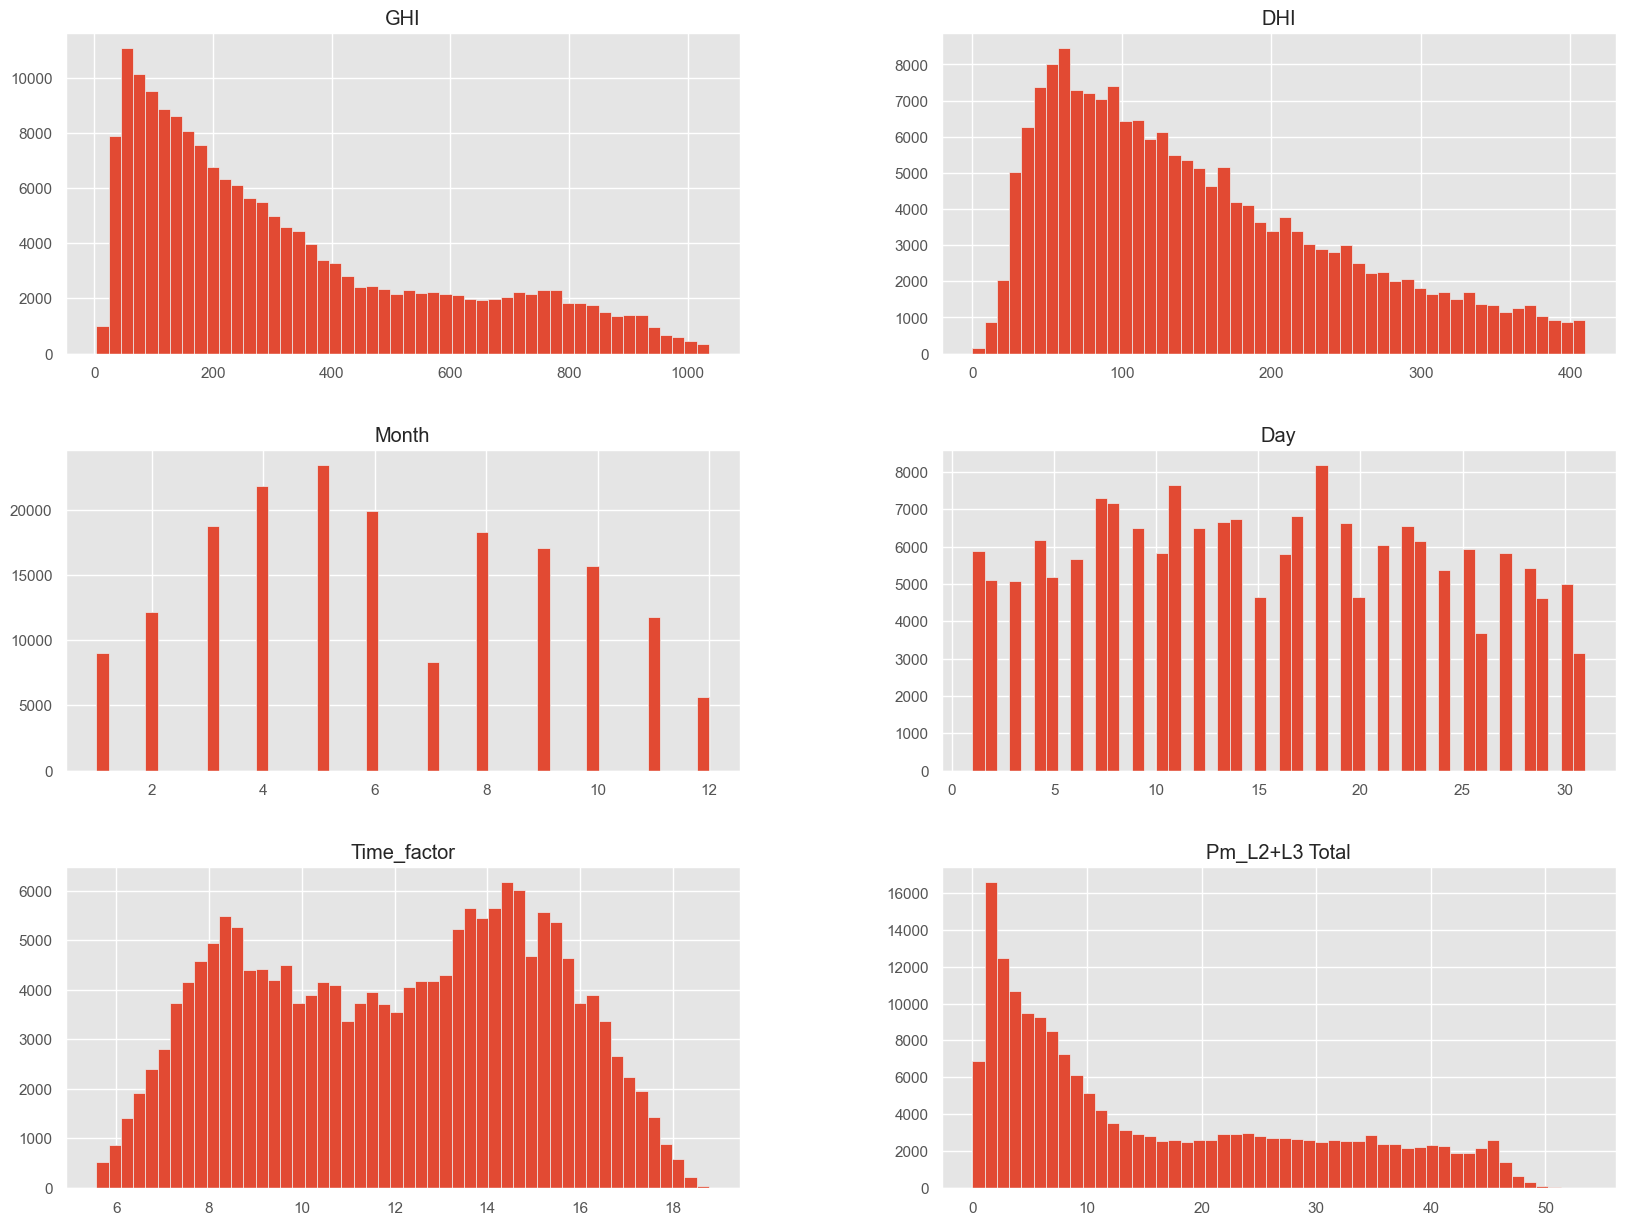

In [16]:
plt.style.use('ggplot')

df_ML.hist(bins=50, figsize=(20,15)) 

# Looking for Numerical Correlations with the Target Column

In [17]:
# Variable Correlations with the target "Pm_L2+L3 Total"

df_ML.corr()['Pm_L2+L3 Total'].sort_values(ascending=False)

Pm_L2+L3 Total    1.000000
GHI               0.651804
DHI               0.114094
Month             0.037414
Day              -0.016531
Time_factor      -0.122810
Name: Pm_L2+L3 Total, dtype: float64

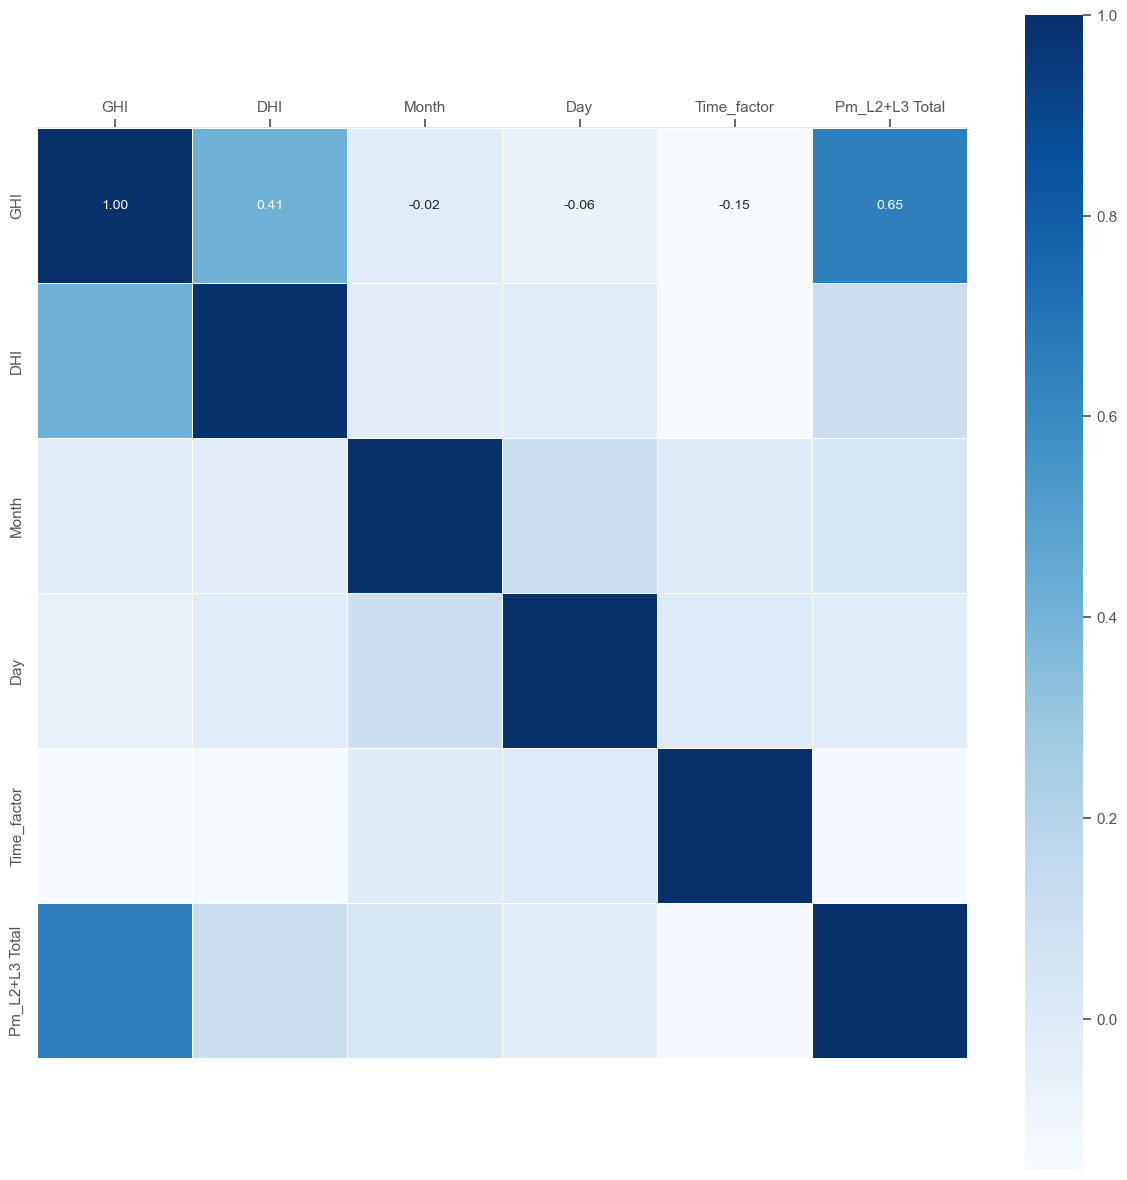

In [18]:
correlation = df_ML.corr()

fig = plt.subplots(figsize=(15,15))
ax = sns.heatmap(correlation, vmax=1, square=True, annot=True, fmt=".2f", cmap='Blues', linewidth=.5)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

## Variance Inflation Factor (VIF)

In [19]:
# To check multicollinearity of features

from statsmodels.stats.outliers_influence import variance_inflation_factor

# the independent variables set
x = df_ML[['GHI', 'DHI', 'Month', 'Day', 'Time_factor']]

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x.values, i)
                          for i in range(len(x.columns))]
  
print(vif_data)

# VIF increases beyond 10: feature with VIF ≥ 10 is highly correlated to other features,
# thus making it redundant for regression analysis and can be omitted

       feature       VIF
0          GHI  3.058264
1          DHI  3.920628
2        Month  4.520206
3          Day  3.906196
4  Time_factor  6.183886


# Multivariate Polynomial Regression - 
# Ordinary Least Squares (OLS) with Standard Scaling

In [20]:
# Prepare training and testing data sets

x = df_ML[['GHI', 'DHI', 'Month', 'Day', 'Time_factor']] #to put independent variable (INPUT)

y = df_ML['Pm_L2+L3 Total'] #to put dependent variable (TARGET)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)


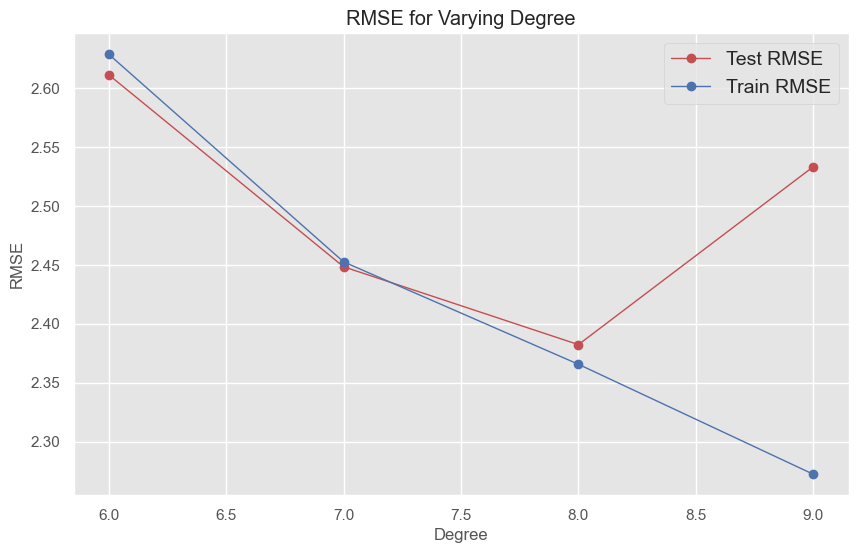


Optimal Degree:  8


In [21]:
# Generate polynomial and interaction features

poly_degree_list = np.arange(6, 10, 1)

# Two lists to store train and validation MSE values for various models of varying complexity
mse_train_list, mse_test_list, r2_train_list, r2_test_list = [], [], [], []

for degree in poly_degree_list:

    # Create a pipeline object: first add polynomials, then standardize, finally create Linear Regression model 
    ols_model = make_pipeline(PolynomialFeatures(degree, include_bias = False), StandardScaler(), LinearRegression()) 
  
    # Train the model
    ols_model.fit(x_train, y_train)
       
    # Make prediction 
    y_train_predicted = ols_model.predict(x_train)
    y_test_predicted = ols_model.predict(x_test)
    
    
    # Compute MSE and add to the list
    mse_train_list.append(mean_squared_error(y_train, y_train_predicted))
    mse_test_list.append(mean_squared_error(y_test, y_test_predicted))
    r2_train_list.append(r2_score(y_train, y_train_predicted))
    r2_test_list.append(r2_score(y_test, y_test_predicted))
   

# Plot RMSE values for varying polynomial degree
plt.figure(figsize=(10, 6))   
plt.plot(poly_degree_list, np.sqrt(mse_test_list), "ro-", alpha=1.0, linewidth=1.0, label="Test RMSE")
plt.plot(poly_degree_list, np.sqrt(mse_train_list), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()


# Find the value of optimal degree for the polynomial that gives smallest validation RMSE
rmse_test = np.sqrt(mse_test_list)
j = 0
min_rmse = rmse_test[j]
optimal_degree = 1

for i in poly_degree_list:
    if(rmse_test[j] < min_rmse):
        min_rmse = rmse_test[j]
        optimal_degree = i
    j +=1
    
print("\nOptimal Degree: ", optimal_degree)

In [22]:
# Create a pipeline object: first add polynomials, then standardize, finally create Linear Regression model 
ols_model = make_pipeline(PolynomialFeatures(degree=optimal_degree, include_bias = False), StandardScaler(), LinearRegression()) 

# Start timing
start_time = time.time()

ols_model.fit(x_train, y_train)

# Stop timing
end_time = time.time()

# Calculate elapsed time
elapsed_time_OLS = end_time - start_time
# Print elapsed time
print("\nOLS Time: {:.10f} seconds".format(elapsed_time_OLS))

# Model Evaluation
y_train_predicted = ols_model.predict(x_train)

ols_train_mse = mean_squared_error(y_train, y_train_predicted)
ols_train_r2_score = r2_score(y_train, y_train_predicted)

print("\n----------------------------- Model Evaluation using Train Data-----------------------------------------\n")
print("Train: Mean squared error: %.2f"
      % ols_train_mse)
print("Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.4f" 
      % ols_train_r2_score)

print("\n----------------------------- Model Evaluation using Test Data -----------------------------------------\n")
# Make prediction 
y_test_predicted = ols_model.predict(x_test)

ols_test_mse = mean_squared_error(y_test, y_test_predicted)
ols_test_r2_score = r2_score(y_test, y_test_predicted)


print("Test: Mean squared error: %.2f"
      % ols_test_mse)
print("Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: %.4f" 
      % ols_test_r2_score)


OLS Time: 21.8305404186 seconds

----------------------------- Model Evaluation using Train Data-----------------------------------------

Train: Mean squared error: 5.60
Train: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.9708

----------------------------- Model Evaluation using Test Data -----------------------------------------

Test: Mean squared error: 5.68
Test: Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.9702


## Object Serialisation - save prediction models to a file to restore for later use
## Sklearn calls it "Model persistence" https://scikit-learn.org/stable/model_persistence.html

In [ ]:
# Method 1: Using joblib module
# For OLS with Polynomial features and Standard Scaler

y_test_predicted = ols_model.predict(x_test)

ols_test_mse = mean_squared_error(y_test, y_test_predicted)
ols_test_r2_score = r2_score(y_test, y_test_predicted)

print("Test: Mean squared error: %.2f"
      % ols_test_mse)
print("Test: Coefficient of determination r^2 variance score: %.4f" 
      % ols_test_r2_score)

import joblib

# Save to file in the current working directory
joblib_file = "ols_model.pkl"
joblib.dump(ols_model, joblib_file)

# Load from file
joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(x_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
y_test_predicted = joblib_model.predict(x_test)

In [ ]:
# Method 2: Manual save and Restor to JSON
# https://stackabuse.com/scikit-learn-save-and-restore-models/
# For Random Forest, without Polynomial features and Standard Scaler

import json
import numpy as np

rnd_forest_reg = RandomForestRegressor(n_estimators=500, criterion="squared_error", max_features=1.0, 
                                       verbose=1, max_depth=8, 
                                       oob_score=True, n_jobs=-1)

class MyLogReg(rnd_forest_reg):
    
    # Override the class constructor
    def __init__(self, C=1.0, solver='liblinear', max_iter=100, X_train=None, Y_train=None):
        LogisticRegression.__init__(self, C=C, solver=solver, max_iter=max_iter)
        self.X_train = X_train
        self.Y_train = Y_train
        
    # A method for saving object data to JSON file
    def save_json(self, filepath):
        dict_ = {}
        dict_['C'] = self.C
        dict_['max_iter'] = self.max_iter
        dict_['solver'] = self.solver
        dict_['X_train'] = self.X_train.tolist() if self.X_train is not None else 'None'
        dict_['Y_train'] = self.Y_train.tolist() if self.Y_train is not None else 'None'
        
        # Create json and save to file
        json_txt = json.dumps(dict_, indent=4)
        with open(filepath, 'w') as file:
            file.write(json_txt)
    
    # A method for loading data from JSON file
    def load_json(self, filepath):
        with open(filepath, 'r') as file:
            dict_ = json.load(file)
            
        self.C = dict_['C']
        self.max_iter = dict_['max_iter']
        self.solver = dict_['solver']
        self.X_train = np.asarray(dict_['X_train']) if dict_['X_train'] != 'None' else None
        self.Y_train = np.asarray(dict_['Y_train']) if dict_['Y_train'] != 'None' else None

In [ ]:
# Method 3: sklearn-json

import sklearn_json as skljson

file_name = "rnd_forest_model.json"

skljson.to_json(rnd_forest_reg, file_name)
deserialised_model = skljson.from_json(file_name)

deserialised_model.predict(x_test)
score = deserialized_model.score(x_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))

In [ ]:
df_ML